# Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed

set_random_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6

LABELS = ["Normal","Break"]

/Users/tinghinyan/opt/anaconda3/envs/crisis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tinghinyan/opt/anaconda3/envs/crisis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tinghinyan/opt/anaconda3/envs/crisis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tinghinyan/o

# Data

**y**
1. **Crisis**: crisisJST

**X**
2. **GDP growth**: gdp/gdp_-1 * 100
3. **CPI growth**: cpi/cpi_-1 * 100

4. **Public sector debt-to-GDP ratio**: debtgdp
5. **Total loans to non-financial private sector-to-GDP ratio**: tloans/gdp 
6. **Mortgage loans to non-financial private sector-to-GDP ratio**: tmort/gdp
7. **Total loans to households-to-GDP ratio**: thh/gdp
8. **Total loans to business-to-GDP ratio**: tbus/gdp

9. **Short-term interest rate**: stir
10. **Long-term interest rate**: ltrate 

11. **Current account-to-GDP ratio**: ca/gdp

12. **Housing capital gain**: housing_capgain
13. **Equity capital gain**: eq_capgain
14. **Government deficit-to-GDP ratio** = (expenditure - revenue)/ gdp
15. **Change in investment** = iy

In [2]:
df = pd.read_excel (r'JSTdatasetR4.xlsx', sheet_name='Data')

df = df[df.columns[df.columns.isin(['year', 'iso', 'crisisJST',
                                    'gdp', 'cpi', 'iy',
                                    'narrowm', 'money',
                                    'debtgdp', 'revenue', 'expenditure',
                                    'tloans', 'tmort', 'thh', 'tbus',
                                    'stir', 'ltrate',
                                    'ca',
                                    'housing_capgain', 'eq_capgain'
                                   ])]]

## Transformation

In [3]:
df.head

<bound method NDFrame.head of       year  iso       gdp        iy         cpi          ca   narrowm  \
0     1870  AUS    208.78  0.109266    2.708333   -6.147594    23.300   
1     1871  AUS    211.56  0.104579    2.666667    5.260774    27.200   
2     1872  AUS    227.40  0.130438    2.541667    7.867636    36.200   
3     1873  AUS    266.54  0.124986    2.541667  -11.047833    38.600   
4     1874  AUS    287.58  0.141960    2.666667   -5.563959    37.900   
...    ...  ...       ...       ...         ...         ...       ...   
2494  2012  USA  16155.30  0.189678  170.439616 -444.593000  2657.124   
2495  2013  USA  16691.50  0.192086  172.915614 -426.197000  3685.277   
2496  2014  USA  17427.60  0.196377  175.745326 -349.544000  3898.497   
2497  2015  USA  18120.70  0.198301  175.947448 -373.796000  3816.062   
2498  2016  USA  18624.50  0.195831  178.170793 -434.603000  3509.753   

             money  stir    ltrate   debtgdp   revenue  expenditure  \
0        54.300000  4.

In [4]:
df = df.rename(columns={"crisisJST": "y"})

df = df.assign(tloans = df['tloans'] / df['gdp'],
               tmort = df['tmort'] / df['gdp'],
               thh = df['thh'] / df['gdp'],
               tbus = df['tbus'] / df['gdp'],
               ca = df['ca'] / df['gdp'],
               deficit = (df['expenditure'] - df['revenue'])/ df['gdp'],
               yield_slope = df['ltrate'] - df['stir'])

In [5]:
df['gdp'] = (df.groupby('iso')['gdp'].apply(pd.Series.pct_change)) 
df['cpi'] = (df.groupby('iso')['cpi'].apply(pd.Series.pct_change)) 
df['narrowm'] = (df.groupby('iso')['narrowm'].apply(pd.Series.pct_change)) 
df['money'] = (df.groupby('iso')['money'].apply(pd.Series.pct_change)) 

df = df[['y'] + [ col for col in df.columns if col != 'y' ]]

# Framing the problem

The objective is to predict a break ***before*** it occurs. For this exerciese, let's define the forecast horizon as t+2. Conceptually this can be done by shifting the y label 2 rows up, or just re-define the label. But here we will do something different - see the psuedo code below.

    If row t == 1:    
    
        set (t-2) and (t-1) = 1
    
        delete t
        
The rationale is simple, the first action allows the classifier learns up to t-2 and we do not want the classifier to predict a break when it has already happened.

## A small utility to acheive this

In [6]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc = 0, column = labelcol + 'tmp', value = vector)
    # Remove the rows with labelcol == 1.
    crisis = df[df[labelcol] == 1].index
    #crisis_1 = crisis + 1
    #crisis_2 = crisis + 2
    df = df.drop(crisis)
    #df = df.drop(crisis_1)
    #df = df.drop(crisis_2)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [7]:
df_grouped = df.groupby('iso')

a = []

for group_name, df_group in df_grouped:
    a.append(curve_shift(df_group, shift_by = -2))

# Shift the response column y by 2 rows to do a 2-year ahead prediction.
df_shifted = pd.concat(a)

### A quick test to make sure it is working as expected

In [8]:
'''
Shift the data by 2 units, equal to 2 years.

Test: Testing whether the shift happened correctly.
'''

print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

print('After shifting')  # Validating if the shift happened correctly.
display(df_shifted.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=6))

Before shifting


,y,year,iso,gdp,iy
20,0,1890,AUS,0.031694,0.169927
21,0,1891,AUS,-0.022471,0.195449
22,0,1892,AUS,-0.082547,0.136706
23,1,1893,AUS,-0.130321,0.111523
24,0,1894,AUS,-0.069357,0.119461


After shifting


,y,year,iso,gdp,iy
20,0.0,1890,AUS,0.031694,0.169927
21,1.0,1891,AUS,-0.022471,0.195449
22,1.0,1892,AUS,-0.082547,0.136706
24,0.0,1894,AUS,-0.069357,0.119461
25,0.0,1895,AUS,-0.038833,0.110825


In [9]:
# Remove time column, and the categorical columns for simplicity
df = df_shifted

# Keep a small subset
df = df[['y', 'year', 'gdp', 'cpi', #'iy',
         #'narrowm',
         'money',
         'ca', 'debtgdp', 'deficit',
         'tloans', #'tmort',
         'yield_slope',
         'eq_capgain', 'housing_capgain']].dropna()
len(df)

1540

# Divide the data into train, valid, and test

In [10]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In the autoencoder, we will be encoding only the negatively labeled data. That is, we will take the part of data for which y=0 and build an autoencoder. For that, we will divide the datasets as following.

In [11]:
# labels
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]

# data
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [12]:
display(df_train_0.head(n=2))

display(df_train_0_x.head(n=2))

,y,year,gdp,cpi,money,ca,debtgdp,deficit,tloans,yield_slope,eq_capgain,housing_capgain
1441,0.0,1988,0.039478,0.007464,0.087038,0.029609,0.737415,0.050837,0.761468,1.599163,0.288267,0.046042
270,0.0,1993,0.029929,0.027476,0.137406,0.051240,1.407598,0.057700,0.821503,-0.931667,0.303066,0.060953


,year,gdp,cpi,money,ca,debtgdp,deficit,tloans,yield_slope,eq_capgain,housing_capgain
1441,1988,0.039478,0.007464,0.087038,0.029609,0.737415,0.050837,0.761468,1.599163,0.288267,0.046042
270,1993,0.029929,0.027476,0.137406,0.051240,1.407598,0.057700,0.821503,-0.931667,0.303066,0.060953


# Standardisation

Here we are doing a MinMax trasnformation, can also do a Guassian thing. Such transformation seems standard for autoencoders.

See scikit learn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [13]:
#scaler = StandardScaler().fit(df_train_0_x)
scaler = MinMaxScaler().fit(df_train_0_x)

df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

# A simple autoencoder

## Train a model

In [14]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
#encoding_dim = 32
encoding_dim = 4
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 48        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 11)                55        
Total params: 131
Trainable params: 131
Non-trainable

In [15]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Instructions for updating:
Use tf.cast instead.
Train on 923 samples, validate on 231 samples
Epoch 1/200
923/923 [==============================] - 0s 175us/step - loss: 0.1539 - accuracy: 0.0423 - val_loss: 0.1418 - val_accuracy: 0.0433
Epoch 2/200
923/923 [==============================] - 0s 13us/step - loss: 0.1434 - accuracy: 0.0401 - val_loss: 0.1323 - val_accuracy: 0.0390
Epoch 3/200
923/923 [==============================] - 0s 11us/step - loss: 0.1336 - accuracy: 0.0368 - val_loss: 0.1234 - val_accuracy: 0.0390
Epoch 4/200
923/923 [==============================] - 0s 11us/step - loss: 0.1245 - accuracy: 0.0368 - val_loss: 0.1149 - val_accuracy: 0.0390
Epoch 5/200
923/923 [==============================] - 0s 11us/step - loss: 0.1160 - accuracy: 0.0368 - val_loss: 0.1070 - val_accuracy: 0.0390
Epoch 6/200
923/923 [==============================] - 0s 11us/step - loss: 0.1081 - accuracy: 0.0368 - val_loss: 0.0996 - val_accuracy: 0.0390
Epoch 7/200
923/923 [====================

923/923 [==============================] - 0s 14us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0146 - val_accuracy: 0.6061
Epoch 56/200
923/923 [==============================] - 0s 15us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0146 - val_accuracy: 0.6061
Epoch 57/200
923/923 [==============================] - 0s 15us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0146 - val_accuracy: 0.6061
Epoch 58/200
923/923 [==============================] - 0s 14us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0146 - val_accuracy: 0.6061
Epoch 59/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0146 - val_accuracy: 0.6061
Epoch 60/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0146 - val_accuracy: 0.6061
Epoch 61/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0146 - val_accuracy: 0.606

923/923 [==============================] - 0s 13us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 112/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 113/200
923/923 [==============================] - 0s 14us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 114/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 115/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 116/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 117/200
923/923 [==============================] - 0s 11us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy:

923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 168/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 169/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 170/200
923/923 [==============================] - 0s 11us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 171/200
923/923 [==============================] - 0s 11us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 172/200
923/923 [==============================] - 0s 12us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy: 0.6061
Epoch 173/200
923/923 [==============================] - 0s 11us/step - loss: 0.0154 - accuracy: 0.6132 - val_loss: 0.0145 - val_accuracy:

In [16]:
autoencoder = load_model('autoencoder_classifier.h5')

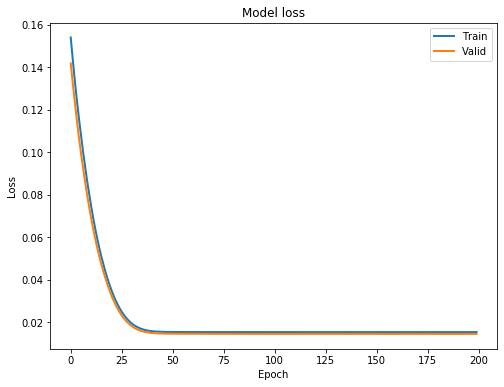

In [17]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

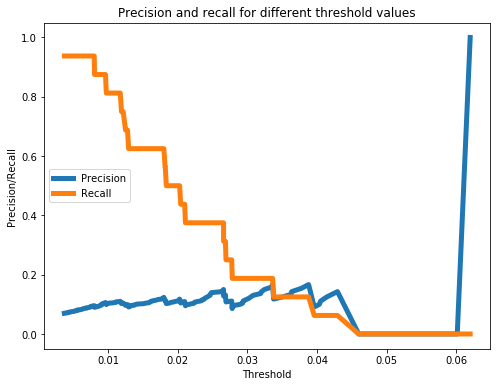

In [18]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [19]:
error_df.groupby('True_class')['Reconstruction_error'].mean()

True_class
0.0    0.014496
1.0    0.021091
Name: Reconstruction_error, dtype: float64

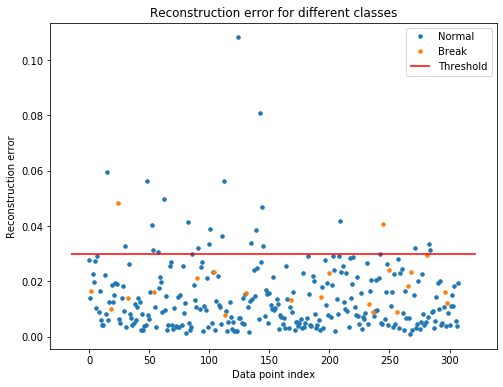

In [20]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

# where does this threshold come from? from visualising the chart above to balance precision and recall.
threshold_fixed = 0.03

groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

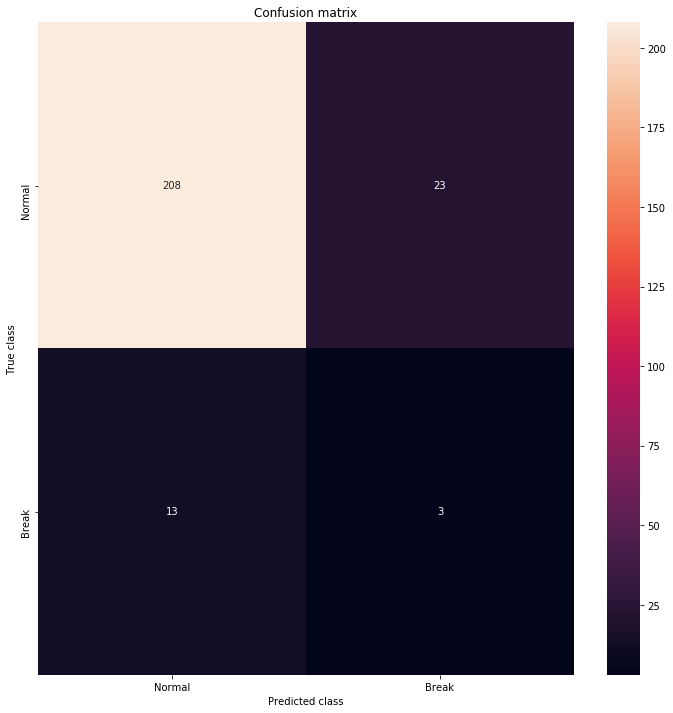

In [21]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

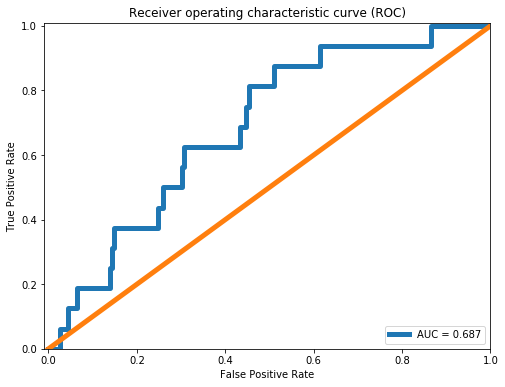

In [22]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Spin up a random forest for comparison

In [23]:
# Train on whole training set
y_train = df_train[['y']]
X_train = df_train.drop(['y'], axis=1)
scaler2 = MinMaxScaler().fit(X_train)

X_train_rescaled = scaler2.transform(X_train)

y_test = df_test[['y']]
X_test = df_test.drop(['y'], axis=1)
X_test_rescaled = scaler2.transform(X_test)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=4)

rf.fit(X_train_rescaled, y_train)

y_pred_rf = rf.predict_proba(X_test_rescaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
auc_rf

/Users/tinghinyan/opt/anaconda3/envs/crisis/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


0.7051017164653529

# ROC to wrap up

What does this all mean?

1. This toy autoencoder doesn't outperform random forest.
2. But if you want a model that has a precision of 80%, then autoencoder gives you fewer false alarms.
3. As for the reason(s) why autoencoder doesn't do well:

    a. Sample size too small, neural networks tend to work well in bigger samples.  
    b. Neural networks need careful tuning but that's lacking in the toy model.

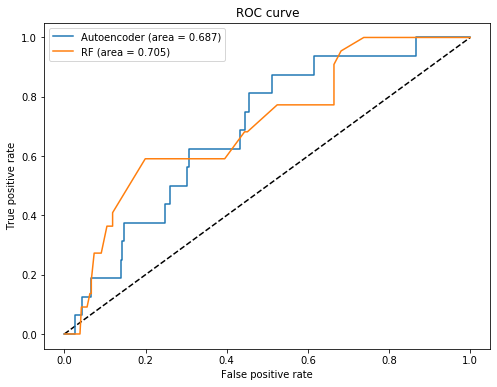

In [24]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_rate, true_pos_rate, label='Autoencoder (area = {:.3f})'.format(roc_auc))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Future reference

## Use LSTM!

Currently we just add in year as a x variable but we can do better than that by building a RNN. LSTM is quite popular. Can also throw in a CNN in.

## Tune the model more carefully

Self-explanatory. TBD.

## Imputing missing values

Had the dataset been bigger than what we have, I would not have bothered to impute them. But the reality is that we do not have a big dataset.

### Get a small example going

In [25]:
#df_trimmed = df.tail(n = 10)
#y_trimmed = df_trimmed[['y', 'year', 'iso']]
#X_trimmed = df_trimmed.drop(['y', 'year', 'iso'], axis=1)

In [26]:
#X_trimmed

### Set up a multivariate imputer

In [27]:
#imputer = IterativeImputer(max_iter = 10, random_state = SEED)
#imputer = KNNImputer(n_neighbors=2)

#imputer.fit(X_trimmed)

#X_trimmed_imputed = imputer.transform(X_trimmed)
#X_trimmed_imputed = pd.DataFrame(data = X_trimmed_imputed, index = X_trimmed.index, columns = X_trimmed.columns)

#df_trimmed_imputed = pd.concat([y_trimmed, X_trimmed_imputed], axis=1)
#display(df_trimmed_imputed)

### Impute by country

In [28]:
#imputed = []

#df_grouped = df.groupby('iso')

#for group_name, df_group in df_grouped:
    
#    y_trimmed = df_group[['y', 'year', 'iso']]
#    X_trimmed = df_group.drop(['y', 'year', 'iso'], axis=1)
    
    #imputer = IterativeImputer(max_iter = 10, random_state = SEED)
#    imputer = KNNImputer(n_neighbors=2)
#    imputer.fit(X_trimmed)
    
#    X_trimmed_imputed = imputer.transform(X_trimmed)
#    X_trimmed_imputed = pd.DataFrame(data = X_trimmed_imputed,
#                                     index = X_trimmed.index,
#                                     columns = X_trimmed.columns)

#    df_trimmed_imputed = pd.concat([y_trimmed, X_trimmed_imputed], axis=1)
    
#    imputed.append(df_trimmed_imputed)

#df_imputed = pd.concat(imputed)